## Calculation of degree 1 terms stokes coefficients from detrended 60-day estimates of the geocenter motion 
Kiana Karimi, Jan 2025

## 01- Load necessary modules

In [1]:
import xarray as xr
import shxarray
import pandas as pd
from shxarray.core.time import decyear2dt
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 02_ Remove Atmosphere-Ocean Dealiasing (AOD-1B) component

In [2]:
## In Progress

## 03_ Calculate Stokes coefficients

In [3]:
datadir = 'sample-data/JPL'
file=os.path.join(datadir,'60_day_geocenter_constrained_heights_detrended.txt')

data = pd.read_csv(file, delim_whitespace=True)
data["time"]= data.YEAR.apply(decyear2dt)
data.set_index("time", inplace = True)

displacement = xr.Dataset.from_dataframe(data).drop_vars("YEAR")
display(displacement)

<xarray.Dataset> Size: 9kB
Dimensions:  (time: 165)
Coordinates:
  * time     (time) datetime64[ns] 1kB 1998-02-03T18:49:32.160002 ... 2024-12...
Data variables:
    X        (time) float64 1kB 19.18 16.59 14.99 12.23 ... 12.36 14.57 12.05
    Y        (time) float64 1kB 0.809 0.015 -3.349 0.227 ... 2.615 4.493 4.147
    Z        (time) float64 1kB -4.676 -11.83 -17.75 ... -16.8 -13.43 -12.1
    X_SIG    (time) float64 1kB 1.47 1.464 1.576 1.404 ... 1.386 1.526 4.696
    Y_SIG    (time) float64 1kB 1.084 1.248 1.494 1.163 ... 0.919 1.092 3.942
    Z_SIG    (time) float64 1kB 3.399 3.705 3.78 3.599 ... 1.841 2.186 7.836

In [4]:
RE = 6378136.3 ## mean radius of the Earth
k1CF = 0.026
pw = 1025
pe = 5517  #3M/(4πa3)
n = 1 #degree

In [5]:
clx= [displacement.X,displacement.Y,displacement.Z]/(np.sqrt(3)*RE)* 10 ** -3

In [6]:
coord = dict(time = ("time", displacement.time.data))

displacement["c11"] = xr.DataArray(clx[0]-np.mean(clx[0]), dims="time", coords=coord)
displacement["s11"] = xr.DataArray(clx[1]-np.mean(clx[1]), dims="time", coords=coord)
displacement["c10"] = xr.DataArray(clx[2]-np.mean(clx[2]), dims="time", coords=coord)

display(displacement)

<xarray.Dataset> Size: 13kB
Dimensions:  (time: 165)
Coordinates:
  * time     (time) datetime64[ns] 1kB 1998-02-03T18:49:32.160002 ... 2024-12...
Data variables:
    X        (time) float64 1kB 19.18 16.59 14.99 12.23 ... 12.36 14.57 12.05
    Y        (time) float64 1kB 0.809 0.015 -3.349 0.227 ... 2.615 4.493 4.147
    Z        (time) float64 1kB -4.676 -11.83 -17.75 ... -16.8 -13.43 -12.1
    X_SIG    (time) float64 1kB 1.47 1.464 1.576 1.404 ... 1.386 1.526 4.696
    Y_SIG    (time) float64 1kB 1.084 1.248 1.494 1.163 ... 0.919 1.092 3.942
    Z_SIG    (time) float64 1kB 3.399 3.705 3.78 3.599 ... 1.841 2.186 7.836
    c11      (time) float64 1kB 3.758e-10 1.411e-10 ... -4.197e-11 -2.701e-10
    s11      (time) float64 1kB 7.748e-11 5.604e-12 ... 4.11e-10 3.796e-10
    c10      (time) float64 1kB 9.326e-10 2.853e-10 ... 1.402e-10 2.61e-10

## 04- Comparison with degree 1 terms from ITSG-Grace2018

* Load degree 1 terms from ITSG-Grace2018

In [7]:
def monthly_solution_icgem(datadir,nmax):

    gsm = []
    deg1_terms = []
    term_c20 = []
    snx = []
    gia = []
    files = os.listdir(datadir)


    for file in files:
        file_path = os.path.join(datadir, file)
        if "ITSG-Grace" and f"n{nmax}" in file:
            gsm.append(xr.open_dataset(file_path, engine="icgem"))
        elif "c20" in file:
            term_c20.append(xr.open_dataset(file_path, engine="icgem"))
        elif "degree1" in file:
            deg1_terms.append(xr.open_dataset(file_path, engine="icgem")) 
            
        elif "snx" and "ITSG-Grace" in file:
            snx.append(xr.open_dataset(file_path, engine = "sinex"))
        
        elif "glacial" in file:
            gia.append(xr.open_dataset(file_path, engine ="icgem"))
    

    if deg1_terms and term_c20 and gia:
        deg1_cnm = xr.concat(deg1_terms, dim="time").sortby("time")
        c20_cnm = xr.concat(term_c20, dim="time").sortby("time")
        glacial = xr.concat(gia, dim = "time").sortby("time")
        return deg1_cnm, c20_cnm, glacial
    elif gsm:
        dsgsm = xr.concat(gsm, dim="time")
        dsgsm = dsgsm.sortby('time')
        return dsgsm
    elif snx:
        sinex = xr.concat(snx, dim = "time").sortby("time")
        return sinex

In [8]:
datadir = os.path.expanduser("~/private/data/ITSG_grace2018/Grace/monthly_background")
ds_deg1,ds_c20 , dsglacial= monthly_solution_icgem(datadir, nmax =120)

In [10]:
display(ds_deg1)
deg1_terms = ds_deg1.sh.truncate(1,1) ## only select degree 1 terms
display(deg1_terms)

<xarray.Dataset> Size: 7kB
Dimensions:  (time: 162, nm: 4)
Coordinates:
  * nm       (nm) object 32B MultiIndex
  * n        (nm) int64 32B 0 1 1 1
  * m        (nm) int64 32B 0 0 1 -1
  * time     (time) datetime64[ns] 1kB 2002-04-15T12:00:00 ... 2017-06-15T12:...
Data variables:
    cnm      (time, nm) float64 5kB 0.0 6.217e-10 ... -6.684e-11 -8.638e-11
Attributes:
    nmaxfile:   1
    nmax:       1
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  model_degree1_2002-04

<xarray.Dataset> Size: 5kB
Dimensions:  (time: 162, nm: 3)
Coordinates:
  * nm       (nm) object 24B MultiIndex
  * n        (nm) int64 24B 1 1 1
  * m        (nm) int64 24B 0 1 -1
  * time     (time) datetime64[ns] 1kB 2002-04-15T12:00:00 ... 2017-06-15T12:...
Data variables:
    cnm      (time, nm) float64 4kB 6.217e-10 1.842e-10 ... -8.638e-11
Attributes:
    nmaxfile:   1
    nmax:       1
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  model_degree1_2002-04

In [11]:
deg1_alined = displacement.sel(time = ds_deg1.time, method ="nearest")

Text(0.5, 1.0, 'Comparison of C10 term')

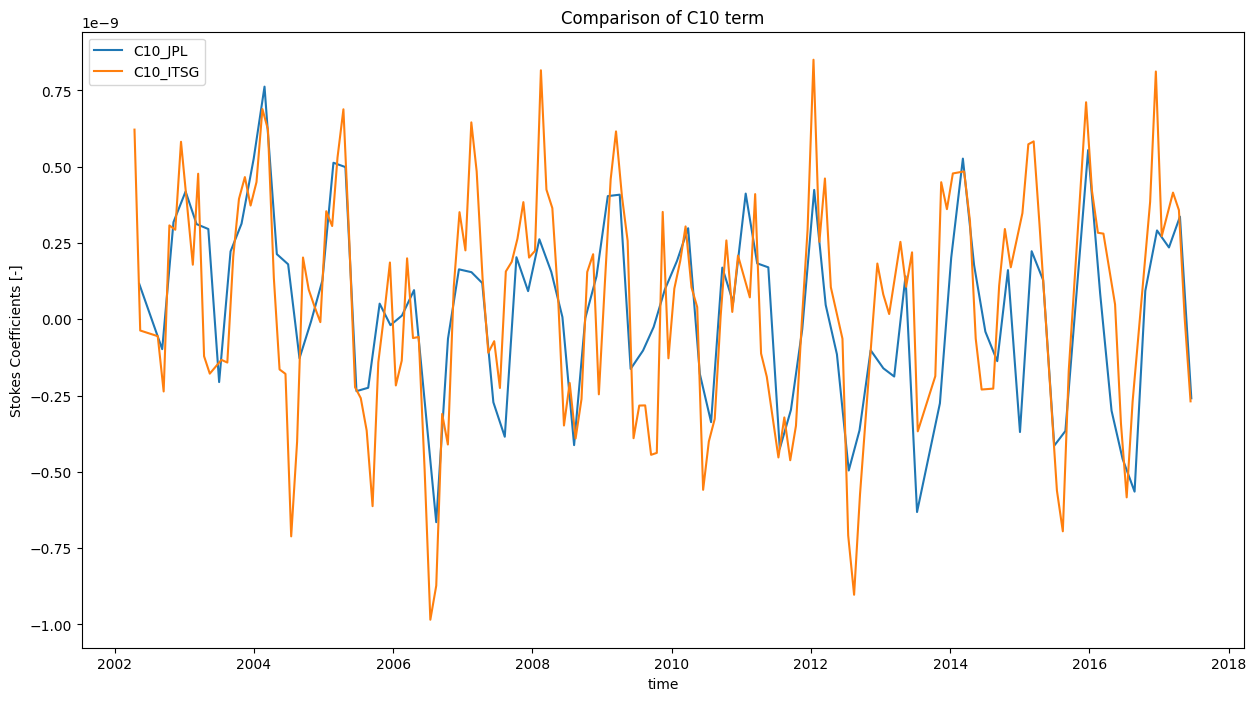

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))


deg1_alined.c10.plot(ax=ax,label='C10_JPL')

deg1_terms.cnm.sel(n=1,m=0).plot(ax=ax,label='C10_ITSG')

plt.legend()
plt.title("Comparison of C10 term")

Text(0.5, 1.0, 'Comparison of C11 term')

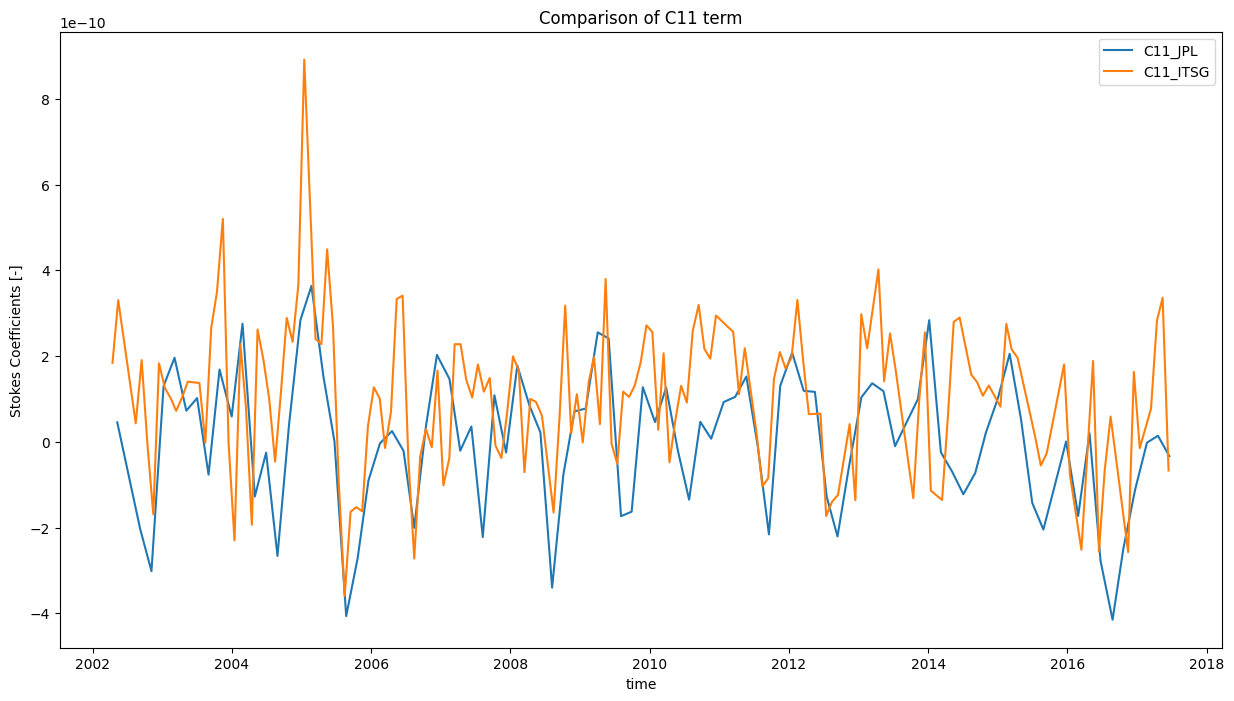

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))


deg1_alined.c11.plot(ax=ax,label='C11_JPL')

deg1_terms.cnm.sel(n=1,m=1).plot(ax=ax,label='C11_ITSG')

plt.legend()
plt.title("Comparison of C11 term")

Text(0.5, 1.0, 'Comparison of S11 term')

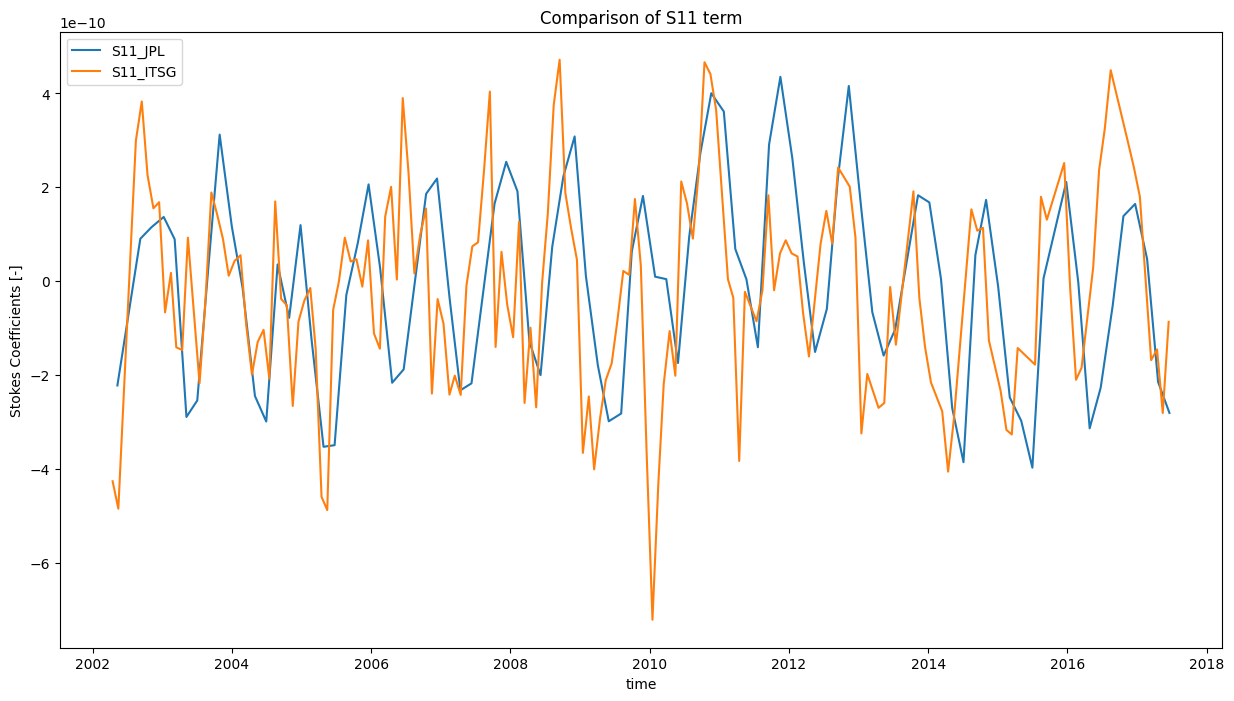

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))


deg1_alined.s11.plot(ax=ax,label='S11_JPL')

deg1_terms.cnm.sel(n=1,m=-1).plot(ax=ax,label='S11_ITSG')

plt.legend()
plt.title("Comparison of S11 term")